<hr/>

## Word Embeddings (Word2Vec) Demo

#### Matching Mission statement and clientele

<hr/>

**Word2Vec** ([Mikolov 2013](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)) is based on the idea that words that appear in similar contexts tend to be semantically similar. A shallow neural network is trained to learn distributed representations (embeddings). Since the algorithm deals with words as autonomous units, we can learn slightly more complex structures using `with_bigrams` or `with_trigrams` in the `word_processing` notebook. If that is not sufficient, we can learn paragraph embeddings instead. This can be seen in the `doc2vec_demo` notebook.

Since the goal is to learn from words in different contexts, a small dataset can be a problem, particularly if few words appear multiple times. To address this, we compare updated embeddings pretrained with a larger dataset (preferably with similar types of texts as the dataset of interest) with another model trained from scratch with the target data only.

**Two model types available** (both from [Mikolov 2013](https://arxiv.org/pdf/1301.3781.pdf)) 
   
   * **Skip-gram** -> attempt to predict the surrounding context of a word.
   
   * **CBOW** (continuous bag-of-word) <- attempt to predict a word based on surrounding context (word position information is lost)
   
One is the reverse of the other.   

<hr/>

<hr/>

A good thing to do in the future would be to use a metric of accuracy - taking the average similarity of words in a document to the word describing the type of clientele, and seeing if it can accurately predict the clientele type based on the similarity of the words included in the mission statement. 

For now, we just made a table with the best matched words to each clientele type to see if some attributes of these groups could be correctly identified. We then used clustering methods to identify some differences between words. 

Using the community art center dataset, we compared the results of a model trained from scratch with a model pretrained on a dataset of a sample of Wikipedia articles, to see if we could leverage some of the information contained in a pretrained model. 

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True) 

import pandas as pd
import random
from prettytable import PrettyTable
import time 
start_time = time.time()
start_cpu = time.process_time()

import gensim
from nltk.stem import PorterStemmer, LancasterStemmer, SnowballStemmer
 
import json
import multiprocessing
cores = multiprocessing.cpu_count() # number of available cores

# local modules
from helper.helper_funs import time_filename, save_folder_file, logged
from methods.word_doc2vec import plot_w2v, make_bigrams, plot_groups_w2v, word2vec_model, pretrained_word2vec

from helper.dk_ipython import toggled, one_cell_toggle

one_cell_toggle()


   * import parameter and data files 

In [2]:
# file with chosen tuning parameters
with open('changeable_parameters/tuning_params.json') as json_file:  
    tune_params = json.load(json_file)

# data file generated by word_process script    
with open('data/processed_data/cleaned_data.json') as json_data:  
    all_data = json.load(json_data)    

# retrieve cleaned data and tuning word2vec params    
all_donnees = all_data['all_donnees']
processed_data = all_data['processed_data']
all_kwargs = tune_params['set_kwargs']
kwargs_w2v = all_kwargs['kwargs_w2v']   

one_cell_toggle()

### Set local parameters/variables

In [3]:
to_log = True                                 # set to True to get log file
seed = all_data['generating_params']['seed']  # seed generating data in word_process script
stemmer = all_data['generating_params']['stemmer']    # method used to stem words in cleaning process

random.seed(seed)
workers = cores
top_n = 20                # number of top words to show
with_adjust_text = True  # smart distribution of words on scatterplot: warning -- much slower if True


if stemmer =='Porter':
    stem_results = PorterStemmer()
elif stemmer =='Lancaster':
    stem_results = LancasterStemmer()    
elif stemmer =='Snowball':
    stem_results = SnowballStemmer('english')  
else:
    print('No/Invalid Stemmer Implemented, adjust `stem_results` in consequence when checking for word similarity')
    
one_cell_toggle()    

In [4]:
if to_log:
    full_path_log = logged(filename='word2vec')

<hr/>

### Viewing Hand Tunable Word2Vec parameters as specified on [tuning_params.json](changeable_parameters/tuning_params.json) file

<hr/>

<br/>

**Clear definitions of each manually-tuned Word2Vec parameters are available in the file, under the key `help_kwargsw2v`.** 

One can fetch individual definitions for reference, or all parameter details can be displayed as below:

<br/>

In [5]:
'''
Note: if more info is needed about the tunable parameters, type help_kwargs... with the parameter number
Example:
'''
x = PrettyTable()
x.title = "Hand tunable parameters - Word2Vec"
fieldnames = ["Parameter", "Data Type", "Definition"]
x.field_names = fieldnames

for fname in fieldnames:    
    x.align[fname] = "l" 

[x.add_row([key, val[0], val[1]]) for key, val in all_kwargs['help_kwargs_w2v'].items()]

print(x)

one_cell_toggle()

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                       Hand tunable parameters - Word2Vec                                                                      |
+--------------+-------------------------+--------------------------------------------------------------------------------------------------------------------------------------+
| Parameter    | Data Type               | Definition                                                                                                                           |
+--------------+-------------------------+--------------------------------------------------------------------------------------------------------------------------------------+
| min_count    | int                     | ignore words that appear less than _                               

### Train Word2Vec Model

Find words similar in meaning to the following categories of clients (taken from hand-curated dataset `data/artbridges_test.csv`):

   * `Main Communities Served`: 'Indigenous', 'Incarcerated', 'Street Involved', 'General', 'Disability'
   
   * `Main Communities Served - Cultural`: 'Intercultural', 'Immigrants'
   
   * `Main Communities Served - Gender`: 'LGBTQ2+', 'Women'
   
   * `Main Communities Served - Age`: 'Adults', 'Seniors', 'Children', 'Youths'

<hr/>

#### Training models

Starting from scratch, then using a pretrained model trained with the `text8` dataset (a selection of English Wikipedia pages). 

In [6]:
bigram_model = word2vec_model(processed_data, workers = cores, **kwargs_w2v)
premodel = pretrained_word2vec(processed_data, 
                               trained_model_name='../pretrained_models/text8w2v_model', 
                               workers = cores, 
                               **kwargs_w2v)


Loading pretrained model...


   * get dict with lists of words positively and negatively correlated to target group 

In [7]:
group_dict = tune_params['client_groups']
group_names = group_dict.keys()

bigram_dict = {}
pretrained_dict = {}

one_cell_toggle()

   * Find most similar words to target group based on newly trained and pretrained models

In [8]:
for key, val in group_dict.items():
    if len(val) == 1:   
        bigram_dict[key] = bigram_model.most_similar(positive=[stem_results.stem(val[0])], 
                                                   topn=top_n, 
                                                   restrict_vocab=None)
        pretrained_dict[key] = premodel.most_similar(positive=[stem_results.stem(val[0])], 
                                                   topn=top_n, 
                                                   restrict_vocab=None)        
    else:
        bigram_dict[key] = bigram_model.most_similar(positive=[stem_results.stem(val[0])], 
                                                   negative=[stem_results.stem(val[1])], 
                                                   topn=top_n, 
                                                   restrict_vocab=None)
        pretrained_dict[key] = premodel.most_similar(positive=[stem_results.stem(val[0])], 
                                                   negative=[stem_results.stem(val[1])], 
                                                   topn=top_n, 
                                                   restrict_vocab=None)        
        
one_cell_toggle()        

### Comparing pretrained vs. regular word embeddings:

* Make tables with resulting words for each groups

In [9]:
table_dict = {}
pretable_dict = {}

for gr in group_names:
    table_dict[gr] = [b_d[0] for b_d in bigram_dict[gr]]
    pretable_dict[gr] = [pre_d[0] for pre_d in pretrained_dict[gr]]

one_cell_toggle()    

### A few examples of the words related to each clientele group:

<hr/>

   * Fully trained on dataset:

In [10]:
pd.DataFrame(table_dict).head(10)

,indigenous,incarcerated,homeless,lgbt,women,youth
0,contemporari_aborigin,forest,brighter,subscrib,deni,distribut
1,mission_statement,gymnasium,kako,fairi_tale,believ,uniti
2,shaman,victoria,digniti,destin,girl,youth_adult
3,non-profession,rbc,unemploy,reput,underestim,video_product
4,urban_aborigin,earlier,crucial,cinemat,instrumentalist,poet
5,mandat,show,devast,film_festiv,capac,spoken_word
6,raven_spirit,okanagan,poor,eye,liberatori,harmoni
7,tradit,summer,stress,divers,colour,vers
8,worldview,save,premis,non-profit_charit,fun,film
9,confluenc,previous,portion,outreel,honest,crew


<hr/>

   * Pre-trained on Wikipedia pages:

In [11]:
pd.DataFrame(pretable_dict).head(10)

,indigenous,incarcerated,homeless,lgbt,women,youth
0,contemporari_aborigin,forest,poor,subscrib,deni,violenc
1,non-profession,victoria,kako,fairi_tale,instrumentalist,team
2,worldview,gymnasium,digniti,outreel,underestim,poetri
3,non-aborigin,synerget,routin,eye,girl,crew
4,raven_spirit,hospic,premis,destin,fun,love
5,shaman,enter,devast,reput,liberatori,ratio
6,confluenc,rbc,unemploy,lgbt,particular,slam
7,expans,save,palestin,church,woman,spoken_word
8,mission_statement,high,brighter,non-profit_charit,feminist,beatbox
9,rubaboo,canadian_stage,incarcer,spectrum,colour,youth-driven


<hr/>

   * Clustering done on embeddings fully trained on dataset: 

Added 2742 words. Shape (2742, 100)


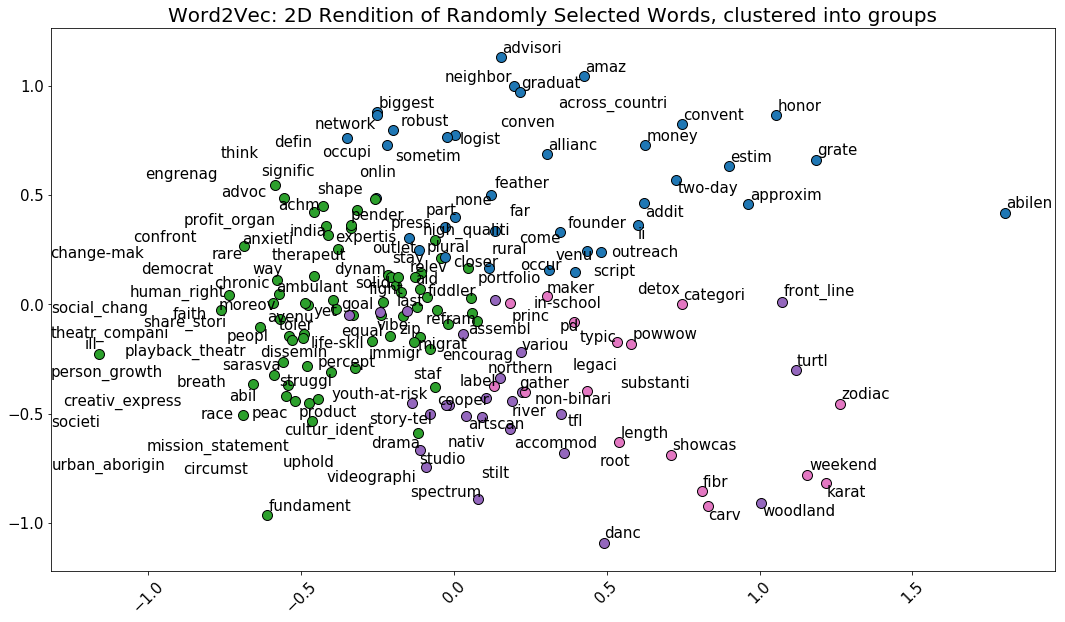

In [15]:
plot_groups_w2v(bigram_model.wv,  # wv fetches `Keyed Vector` type with resulting embeddings 
                max_idx = 150, 
                n_clusters = 4,
                with_adjust_text = with_adjust_text, 
                random_state = seed,
                title = 'Word2Vec: 2D Rendition of Randomly Selected Words, clustered into groups')

<hr/>

   * Clustering done on data pre-trained on Wikipedia pages and updated with our dataset:

Added 2742 words. Shape (2742, 100)


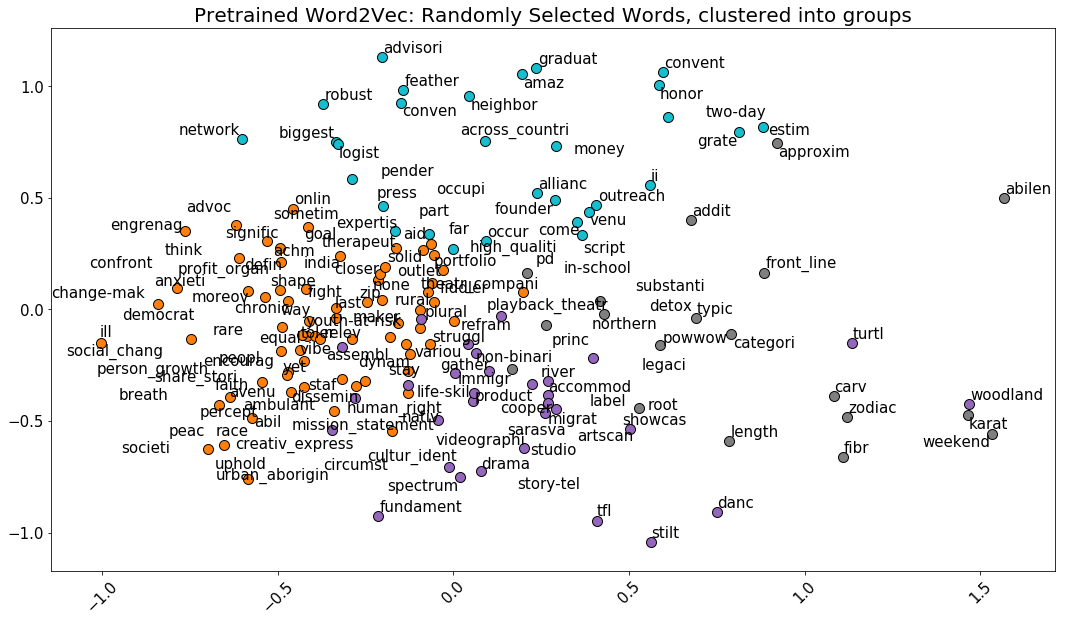

In [16]:
plot_groups_w2v(premodel.wv, max_idx = 150, 
                             n_clusters = 4,
                             with_adjust_text = with_adjust_text, 
                             random_state = seed,
                             title = 'Pretrained Word2Vec: Randomly Selected Words, clustered into groups')

In [14]:
end_time = time.time()
end_cpu = time.process_time()

time_taken = end_time - start_time
cpu_time = end_cpu - start_cpu
print('Time elapsed to run code:{}\nCPU time elapsed:{}'.format(time_taken, cpu_time))

Time elapsed to run code:219.0404269695282
CPU time elapsed:215.711049
